In [2]:
%load_ext tensorboard
import random
import sys
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image, ImageDraw
from torch import nn
from torch.utils.tensorboard.writer import SummaryWriter

plt.style.use(r'C:\Users\BBA\.matplotlib\styles\standard.mplstyle')
sys.path.append(r"C:\Users\BBA\Coding\Resources")
import btk
import dataset_generators as dgen


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
test = dgen.bg_words(1, 2, dgen.trainfonts)[0][0]
display(Image.fromarray(test))

In [3]:
trainx, trainy, valx, valy = btk.depickler('trainx-1639297263', 'trainy-1639297263', 'valx-1639297263', 'valy-1639297263')

""" trainx, trainy = dgen.character_spaces(30000, dgen.trainfonts)
valx, valy = dgen.character_spaces(3000, dgen.evalfonts)
num = btk.pickle_set(trainx, trainy, valx, valy)
display(num) """

trainx, valx = btk.standardize(trainx), btk.standardize(valx)
train = btk.DataGen(trainx, trainy, batch_len=1)
val = btk.DataGen(valx, valy, batch_len=1)

tdata = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
vdata = torch.utils.data.DataLoader(val, batch_size=256, shuffle=True)

In [4]:
for x in range(15):
    display(Image.fromarray(btk.expand_data(trainx[x], 255)))
    display(trainy[x])


#display(Image.fromarray(tester))

1

0

1

0

1

0

1

0

1

0

1

0

1

0

1

In [23]:
display(np.min([1, 2, 3]))

1

In [2]:
class CharSeperator(nn.Module):
    #32 x 12 input -> 16 x 6 -> 8 x 3

    def __init__(self):
        super(CharSeperator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.conv3 = nn.Conv2d(32, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.mpool = nn.MaxPool2d(2, stride=1)
        self.drop = nn.Dropout(0.16)
        self.fc1 = nn.Linear(6144, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.mpool(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool(x)
        x = x.view(-1, 64 * 24 * 4)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_cycle(epi, tboard_writer):
    current_loss = 0.0
    last_loss = 0.0
    for i, item in enumerate(tdata):
        data, labels = item[0].to('cuda'), item[1].to('cuda')
        opti.zero_grad()
        out = space_model(data)
        loss = loss_fn(out, labels)
        loss.backward()
        opti.step()
        current_loss += loss.item()
        
        if i % 257 == 255:
            last_loss = current_loss / 256
            print(f'Batch: {i} | Loss {round(last_loss, 5)}')
            tboard_x = epi * len(tdata) + i + 1
            tboard_writer.add_scalar('Loss / Batch', last_loss, tboard_x)
            current_loss = 0.0
    return last_loss

def val_cycle():
    current_loss = 0.0
    for i, vitem in enumerate(vdata):
        datav, labelsv = vitem[0].to('cuda'), vitem[1].to('cuda')
        with torch.no_grad():
            out = space_model(datav)
        loss = loss_fn(out, labelsv)
        current_loss += loss
        avg_loss = current_loss / (i + 1)
    return avg_loss

cycle_id = round(time.time())
space_model = CharSeperator().to("cuda")
loss_fn = nn.BCEWithLogitsLoss()
opti = torch.optim.Adam(space_model.parameters(), lr=0.001, weight_decay=1e-5)
writer = SummaryWriter(f'runs/word_segmentation_{cycle_id}')

epoch_number = 0
best = 999999

for epoch in range(6):
    print('EPOCH {}:'.format(epoch_number + 1))

    #Training
    space_model.train(True)
    tloss = train_cycle(epoch_number, writer)
    #Validation
    space_model.train(False)
    vloss = val_cycle()

    #Logging / Maintenance
    print(f'Losses: Train {round(float(tloss), 5)} Validation {round(float(vloss), 5)} Validation Accuracy {round((1 - round(float(vloss), 5)) * 100, 5)}%')
    writer.add_scalars('Training vs. Validation Loss', {'Training':tloss, 'Validation':vloss }, epoch_number + 1)
    writer.flush()
    epoch_number += 1
    if vloss < best:
        best = vloss
        torch.save(space_model.state_dict(), f'space_model_{cycle_id}')
print(best)
print(f'space_model_{cycle_id}')


In [2]:
class CharSeperator(nn.Module):
    #32 x 12 input -> 16 x 6 -> 8 x 3

    def __init__(self):
        super(CharSeperator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.conv3 = nn.Conv2d(32, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.mpool = nn.MaxPool2d(2, stride=1)
        self.drop = nn.Dropout(0.16)
        self.fc1 = nn.Linear(6144, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.mpool(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool(x)
        x = x.view(-1, 64 * 24 * 4)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def draw_sep(img, seps):
    ymax = im.size[1]
    for x in seps:
        ImageDraw.Draw(img).line([x, 0, x, ymax], 0, 1)
    return img

space_model = CharSeperator()
space_model.load_state_dict(torch.load(r'C:\Users\BBA\Coding\ComputerVision\reading\segmentation\space_model_1639298180'))
space_model.eval()


CharSeperator(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (mpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.16, inplace=False)
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:

with open('testim', 'rb') as f:
    iar = np.load(f)

im = Image.fromarray(iar)
slices, idx = btk.img_slicer((32, 12), iar, 1, 'v')
slices = [torch.from_numpy(btk.standardize(x)).unsqueeze(0).unsqueeze(0) for x in slices]

with torch.no_grad():
    preds = [float(torch.sigmoid(space_model(x))) for x in slices]

answers = [btk.diff_compress(idx)[i] for i, x in enumerate(preds) if x > 0.8]
old = 0
rlist = []
for x in answers:
    if x == old + 1:
        rlist.append(x)
    old = x
for x in rlist:
    answers.remove(x)

answers = [x for x in answers]
display(rlist)
#test = np.array(Image.fromarray(test).resize((141, 32)))
#crits = btk.criticals(preds, idx)
#display(preds)

display(answers)
display(im)
old = 0
for x in answers:
    display(Image.fromarray(iar[:, old:x]))
    old = x
#display(Image.fromarray(iar[:, 50:55]))

In [7]:

with Image.open(r'C:\Users\BBA\Coding\POE\invite3.png') as ttt:
    bgtst = btk.fit2dims((32, 32), btk.grey_np(ttt.crop((2050, 850, 2560, 1050)).copy()))

coords = (90, 118, 13, 243)
im = Image.fromarray(bgtst[90:118, 13:243]).resize((round(32 / 28 * 230), 32))
iar = np.array(im)

slices, idx = btk.img_slicer((32, 12), im, 1, 'v')
display(slices[0])
slices = [torch.from_numpy(btk.standardize(x)).unsqueeze(0).unsqueeze(0) for x in slices]

with torch.no_grad():
    preds = [float(torch.sigmoid(space_model(x))) for x in slices]

array([[ 62,  54,  14,  51, 104,  86,  32,  36,  37,  37,  39,  42],
       [ 31,  31,  17,  68, 108,  76,  28,  33,  36,  38,  38,  41],
       [ 39,  34,  48,  97, 108,  63,  27,  32,  37,  39,  39,  42],
       [ 65,  59,  72, 101,  92,  48,  32,  36,  38,  39,  41,  44],
       [ 69,  66,  62,  70,  62,  39,  37,  40,  40,  41,  43,  44],
       [ 48,  47,  39,  38,  39,  38,  38,  40,  43,  44,  44,  43],
       [ 35,  33,  34,  37,  39,  39,  39,  41,  44,  44,  44,  43],
       [ 40,  38,  38,  39,  41,  41,  41,  41,  43,  43,  44,  44],
       [ 45,  43,  40,  40,  42,  42,  41,  40,  42,  43,  44,  43],
       [ 45,  43,  41,  41,  42,  42,  40,  40,  42,  43,  42,  41],
       [ 45,  43,  41,  41,  42,  42,  40,  40,  42,  43,  40,  37],
       [ 46,  43,  41,  42,  42,  42,  41,  40,  40,  39,  37,  34],
       [ 46,  43,  41,  42,  43,  42,  41,  40,  38,  37,  36,  32],
       [ 46,  43,  41,  43,  44,  44,  42,  40,  37,  37,  37,  30],
       [ 46,  43,  42,  44,  45,  

In [ ]:
def predict(img, dims, sdims)

(263, 32)

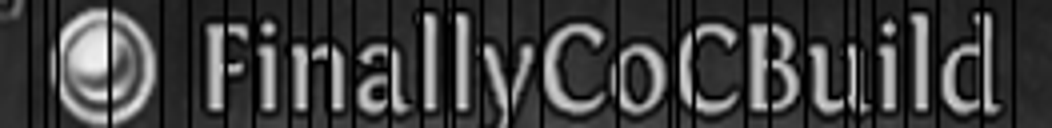

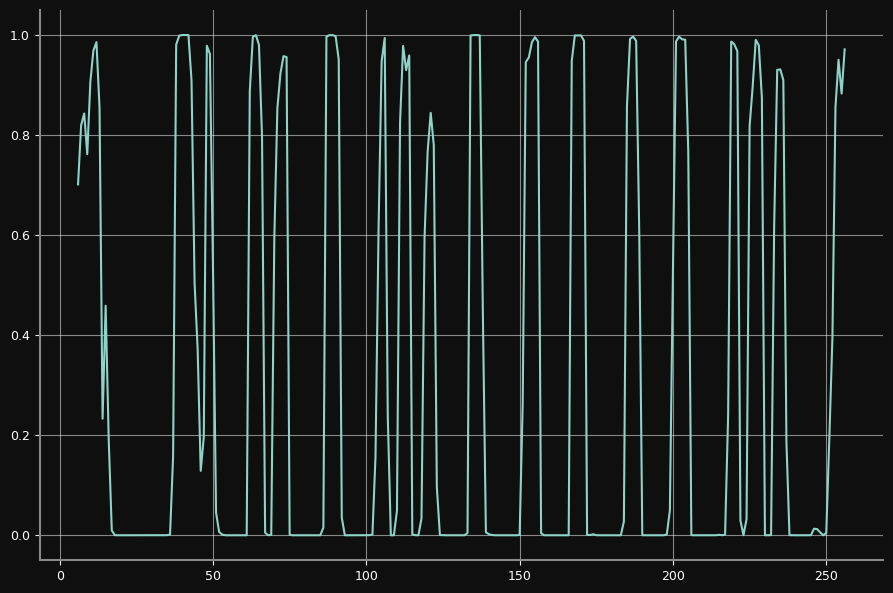

In [6]:
with Image.open(r'C:\Users\BBA\Coding\ComputerVision\reading\segmentation\segtest.png') as ttt:
    iar = btk.fit2dims((32, 32), btk.grey_np(ttt))

im = Image.fromarray(iar)

slices, idx = btk.img_slicer((32, 12), im, 1, 'v')
slices = [torch.from_numpy(btk.standardize(x)).unsqueeze(0).unsqueeze(0) for x in slices]

crits = btk.criticals(preds, idx)
crits = [x[0] for x in crits if x[1] == 'max']
drawn = draw_sep(im, crits)
display(drawn.size)
display(drawn.resize((drawn.size[0] * 2, drawn.size[1] * 2)))

fig = plt.figure()
ax = plt.axes()

plt.plot(btk.diff_compress(idx), preds)
plt.plot()
plt.show()


(263, 32)

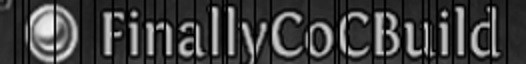

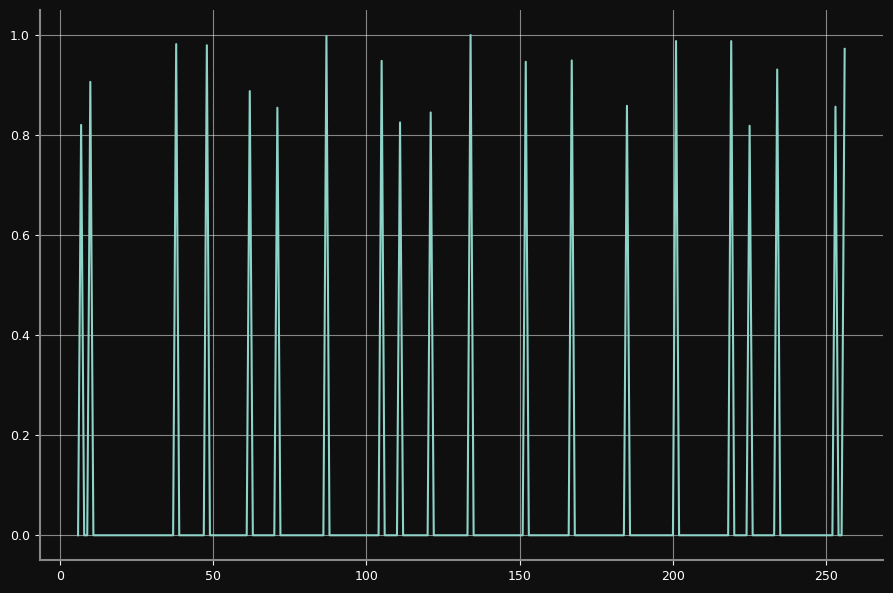

In [67]:
with Image.open(r'C:\Users\BBA\Coding\POE\invite3.png') as ttt:
    bgtst = btk.fit2dims((32, 32), btk.grey_np(ttt.crop((2050, 850, 2560, 1050)).copy()))

coords = (90, 118, 13, 243)
im = Image.fromarray(bgtst[90:118, 13:243]).resize((round(32 / 28 * 230), 32))
iar = np.array(im)

slices, idx = btk.img_slicer((32, 12), im, 1, 'v')
slices = [torch.from_numpy(btk.standardize(x)).unsqueeze(0).unsqueeze(0) for x in slices]

with torch.no_grad():
    preds = [float(torch.sigmoid(space_model(x))) for x in slices]

for i, x in enumerate(preds):
    if x <= 0.8:
        preds[i] = 0

last = 0
for i, x in enumerate(preds):
    if i == len(preds) - 1:
        break
    """ if x > last and preds[i + 1] < x:
        cpoint = x
        current = cpoint
        counter = 1
        while current != 0:
            if i + counter == len(preds) - 1:
                break
            current = preds[i + counter]
            preds[i + counter] = 0
            counter += 1 """
    if last == 0 and x != 0:
        cpoint = x
        current = cpoint
        counter = 1
        while current != 0:
            if i + counter == len(preds) - 1:
                break
            current = preds[i + counter]
            preds[i + counter] = 0
            counter += 1
    last = x

fig = plt.figure()
ax = plt.axes()

fcrits = [i for i, x in enumerate(preds) if x > 0]
drawn = draw_sep(im, crits)
display(drawn.size)
display(drawn.resize((drawn.size[0] * 2, drawn.size[1] * 2)))

plt.plot(btk.diff_compress(idx), preds)
plt.plot()
plt.show()

In [70]:
display(crits)
display(fcrits)

[7,
 11,
 14,
 27,
 40,
 47,
 56,
 63,
 72,
 77,
 82,
 88,
 97,
 105,
 111,
 113,
 120,
 127,
 135,
 154,
 167,
 169,
 173,
 186,
 192,
 201,
 211,
 214,
 218,
 226,
 234,
 245,
 253]

[1,
 4,
 32,
 42,
 56,
 65,
 81,
 99,
 105,
 115,
 128,
 146,
 161,
 179,
 195,
 213,
 219,
 228,
 247,
 250]

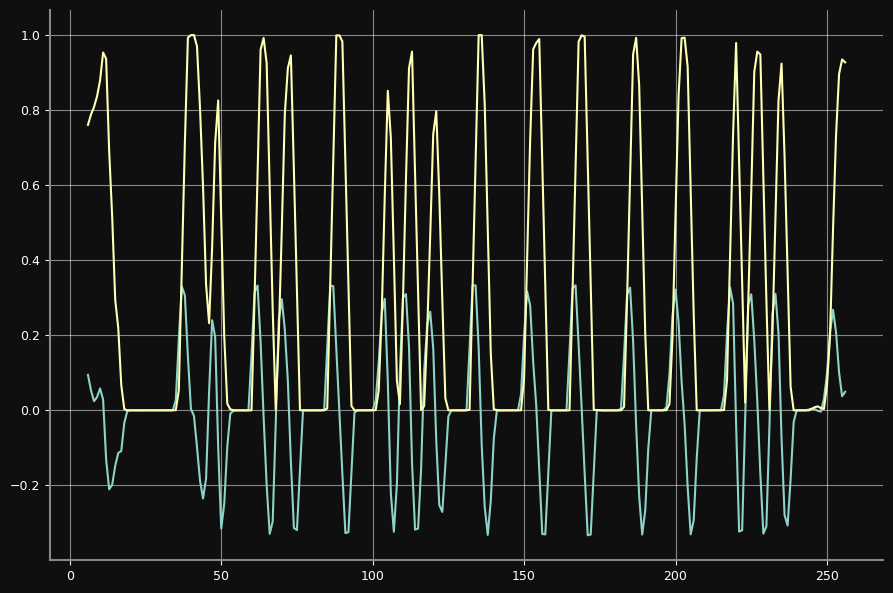

In [34]:
fig = plt.figure()
ax = plt.axes()

#plt.plot(btk.diff_compress(idx), btk.smooth_avg(np.gradient(grads)))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(grads))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(preds))
plt.show()